# Kidney Function and Mortality in the United Arab Emirates - A Predictive Modeling Approach: Python Code

by Leonid Shpaner  

This notebook delves into the intricate landscape of kidney function and mortality using Python. Through data exploration, visualization, and machine learning techniques, it aims to provide insights into the prevalence, risk factors, and predictive modeling of mortality with respect to kidney failure in the UAE.

The burden of Chronic Kidney Disease (CKD) is a pressing global health issue, and its impact on public health in the UAE is of particular concern. By leveraging Python's powerful libraries such as `Pandas`, `NumPy`, `Matplotlib`, and `scikit-learn`, a robust analytical framework has been developed to tackle this challenge head-on.

Throughout this notebook, you'll find detailed explanations, code snippets, visualizations, and interpretations of the data. The analysis aims to maintain clarity and transparency, making it accessible to both technical and non-technical audiences alike.

Whether you're a healthcare professional, data scientist, or simply curious, this notebook serves as a valuable resource for exploring, analyzing, and contributing to furthering our understanding of Chronic Kidney Disease in the United Arab Emirates.

Let's dive into the code and uncover the insights together!

In [1]:
from google.colab import drive
drive.mount("/content/drive") # Mount Google Drive

import sys # Add virtual env's site-packages to sys.path
sys.path.append('/content/drive/MyDrive/ckd_env/lib/python3.10/site-packages')

# Change working directory
%cd '/content/drive/MyDrive/kidney_uae/'

# Prepare activation script for virtual env
!echo "source /content/drive/MyDrive/ckd_env/bin/activate" > activate.sh

# Make scripts and binaries executable
!chmod +x activate.sh
!chmod +x /content/drive/MyDrive/ckd_env/bin/python
!chmod +x /content/drive/MyDrive/ckd_env/bin/pip

%env BASH_ENV=activate.sh # Set BASH_ENV to activate virtual env

print() # New line for clarity
!python --version # Check Python version

Mounted at /content/drive
/content/drive/MyDrive/kidney_uae
env: BASH_ENV=activate.sh # Set BASH_ENV to activate virtual env

Python 3.10.12


# Preprocessing: Kidney_UAE

## Load Requisite Libraries

In [2]:
######################## Standard Library Imports ##############################
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess

##################### import model libraries ###################################
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from lifelines import CoxPHFitter, KaplanMeierFitter
import shap  # shap explainer library
################################################################################

######################### import model metrics #################################
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    r2_score,
    brier_score_loss,
    confusion_matrix,
)

########################### Miscellaneous ######################################
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore") # suppress warnings

from functions import *  # import custom functions
################################################################################
##################### import Bias & Fairness Analysis Tools ####################
from aequitas import Audit
################################################################################

## Read File From Path and Explore Basic Structure

In [3]:
# Change directory to where functions.py is located if it's not in '/content'
data_path = "/content/drive/MyDrive/kidney_uae/data/"
eda_path = "/content/drive/MyDrive/kidney_uae/data/df_eda/"
image_path = "/content/drive/MyDrive/kidney_uae/images/"

In [4]:
# read in the data from an excel file
df = pd.read_excel(os.path.join(data_path, "kidney_uae.xlsx")).set_index("id")

In [5]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in this dataset.")

There are 1186 rows and 11 columns in this dataset.


In [6]:
df.head()  # print first 5 rows of dataframe

,sex,cancer,smoking,obesity,hypertension,dyslipidemia,diabetes,cardiovascular_disease,creatnine,outcome,time(months)
id,,,,,,,,,,,
1,0,0,0,1,1,1,0,0,59.0,0,116
2,0,0,0,1,1,1,0,0,52.0,0,116
3,0,0,0,1,1,1,0,0,57.0,0,101
4,0,0,0,1,0,1,0,0,65.0,0,117
5,0,0,0,1,1,1,1,0,70.0,0,119


## Reorder and Rename Columns

In [7]:
# Shift column 'time(months)' one place to the left
df = move_column_before(
    df=df,
    target_column="time(months)",
    before_column="sex",
)

In [8]:
print(f"New order of columns: {df.columns.to_list()}")  # list new order of cols

New order of columns: ['time(months)', 'sex', 'cancer', 'smoking', 'obesity', 'hypertension', 'dyslipidemia', 'diabetes', 'cardiovascular_disease', 'creatnine', 'outcome']


In [9]:
# rename the following colnames: time(months), creatnine
df.rename(
    columns={"time(months)": "time_months", "creatnine": "creatinine"},
    inplace=True,
)

## Create EDA Dataset

In [10]:
df_eda = df.copy(deep=True)  # create new dataframe specifically for EDA
df_eda["time_years"] = round(df_eda["time_months"] / 12, 1)

In [11]:
# Define bins so that there's a clear bin for > 10 up to max
# (and potentially slightly beyond)
# Note: The last bin captures all values from 10.0 up to and including max and
# slightly beyond, if necessary
year_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, float("inf")]
year_labels = [
    "0-1_years",
    "1-2_years",
    "2-3_years",
    "3-4_years",
    "4-5_years",
    "5-6_years",
    "6-7_years",
    "7-8_years",
    "8-9_years",
    "9-10_years",
    "10_years_plus",
]

# Apply the binning
df_eda["year_bins"] = pd.cut(
    df_eda["time_years"],
    bins=year_bins,
    labels=year_labels,
    include_lowest=True,
    right=True,
)

In [12]:
# create separate dataframe for expanded modeling with one-hot-encoded year bins
df_years = (
    df_eda.copy(deep=True)
    .assign(**pd.get_dummies(df_eda["year_bins"]))
    .drop(columns=["time_months", "time_years", "year_bins"])
)

## Split the Data and Export Datasets to Path

In [13]:
# Dictionary with the data frame names as keys and the data frames as values
model_frames = {"df_original": df, "df_years": df_years, "df_eda": df_eda}
base_output_dir = data_path  # Base directory to save the splits

########################### Stratification parameters ##########################
stratify_years = [col for col in df_years.columns if "_years" in col]
stratify_regular = ["sex"]
################################################################################

for frame_name, frame_data in model_frames.items():
    # Independent variables, excluding 'outcome'
    X = frame_data[[col for col in frame_data.columns if col != "outcome"]]
    # Dependent variable
    y = frame_data["outcome"]

    # if original dataframe, stratify by 'sex', otherwise, stratify by 'years'
    if frame_name == "df_original":
        stratify_by = frame_data[stratify_regular]
    elif frame_name == "df_years":
        stratify_by = frame_data[stratify_years]
    else:
        stratify_by = None

    # Train-test split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=stratify_by,
        random_state=222,
    )

    # Directory for this data frame's splits
    output_dir = os.path.join(base_output_dir, frame_name)
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    frame_data.to_parquet(
        os.path.join(output_dir, f"{frame_name}.parquet")
    )  # export out EDA dataset

    # Check to only save splits if not working with df_eda
    if frame_name != "df_eda":
        dataset_dict = {
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test,
        }

        # save out X_train, X_test, y_train, y_test to appropriate path(s)
        for name, item in dataset_dict.items():
            file_path = os.path.join(
                output_dir, f"{name}.parquet"
            )  # Correctly define the file path
            if not isinstance(item, pd.DataFrame):
                item.to_frame(name="outcome").to_parquet(
                    file_path
                )  # Convert Series to DataFrame and save
            else:
                item.to_parquet(file_path)  # Save DataFrame directly

    # Check if the DataFrame is not 'df_eda', then save the joined X_train,
    # y_train, and X_test, y_test DataFrames
    if frame_name != "df_eda":
        train_data = X_train.join(y_train, on="id", how="inner")
        test_data = X_test.join(y_test, on="id", how="inner")
        train_data.to_parquet(os.path.join(output_dir, "df_train.parquet"))
        test_data.to_parquet(os.path.join(output_dir, "df_test.parquet"))

In [14]:
print(f"Training Size = {X_train.shape[0]}")
print(f"Test Size = {X_test.shape[0]}")
print()
print(
    f"Training Percentage = {X_train.shape[0] / (X_train.shape[0] + X_test.shape[0])*100:.0f}%"
)
print(
    f"Test Percentage = {X_test.shape[0] / (X_train.shape[0] + X_test.shape[0])*100:.0f}%"
)

Training Size = 948
Test Size = 238

Training Percentage = 80%
Test Percentage = 20%


# Exploratory Data Analysis: Kidney_UAE

In [15]:
df_eda = pd.read_parquet(eda_path + "df_eda.parquet")

In [16]:
df_eda.head()

,time_months,sex,cancer,smoking,obesity,hypertension,dyslipidemia,diabetes,cardiovascular_disease,creatinine,outcome,time_years,year_bins
id,,,,,,,,,,,,,
1,116,0,0,0,1,1,1,0,0,59.0,0,9.7,9-10_years
2,116,0,0,0,1,1,1,0,0,52.0,0,9.7,9-10_years
3,101,0,0,0,1,1,1,0,0,57.0,0,8.4,8-9_years
4,117,0,0,0,1,0,1,0,0,65.0,0,9.8,9-10_years
5,119,0,0,0,1,1,1,1,0,70.0,0,9.9,9-10_years


In [17]:
df_eda.shape[0]

1186

In [18]:
df_eda["sex"].value_counts()  # value_counts of sex

1    641
0    545
Name: sex, dtype: int64

## Serum Creatinine Levels (in $\mu mol/L$)

The dataset that the authors have furnished measures SCr in $\mu mol/L$ as opposed to $mg/dL$.

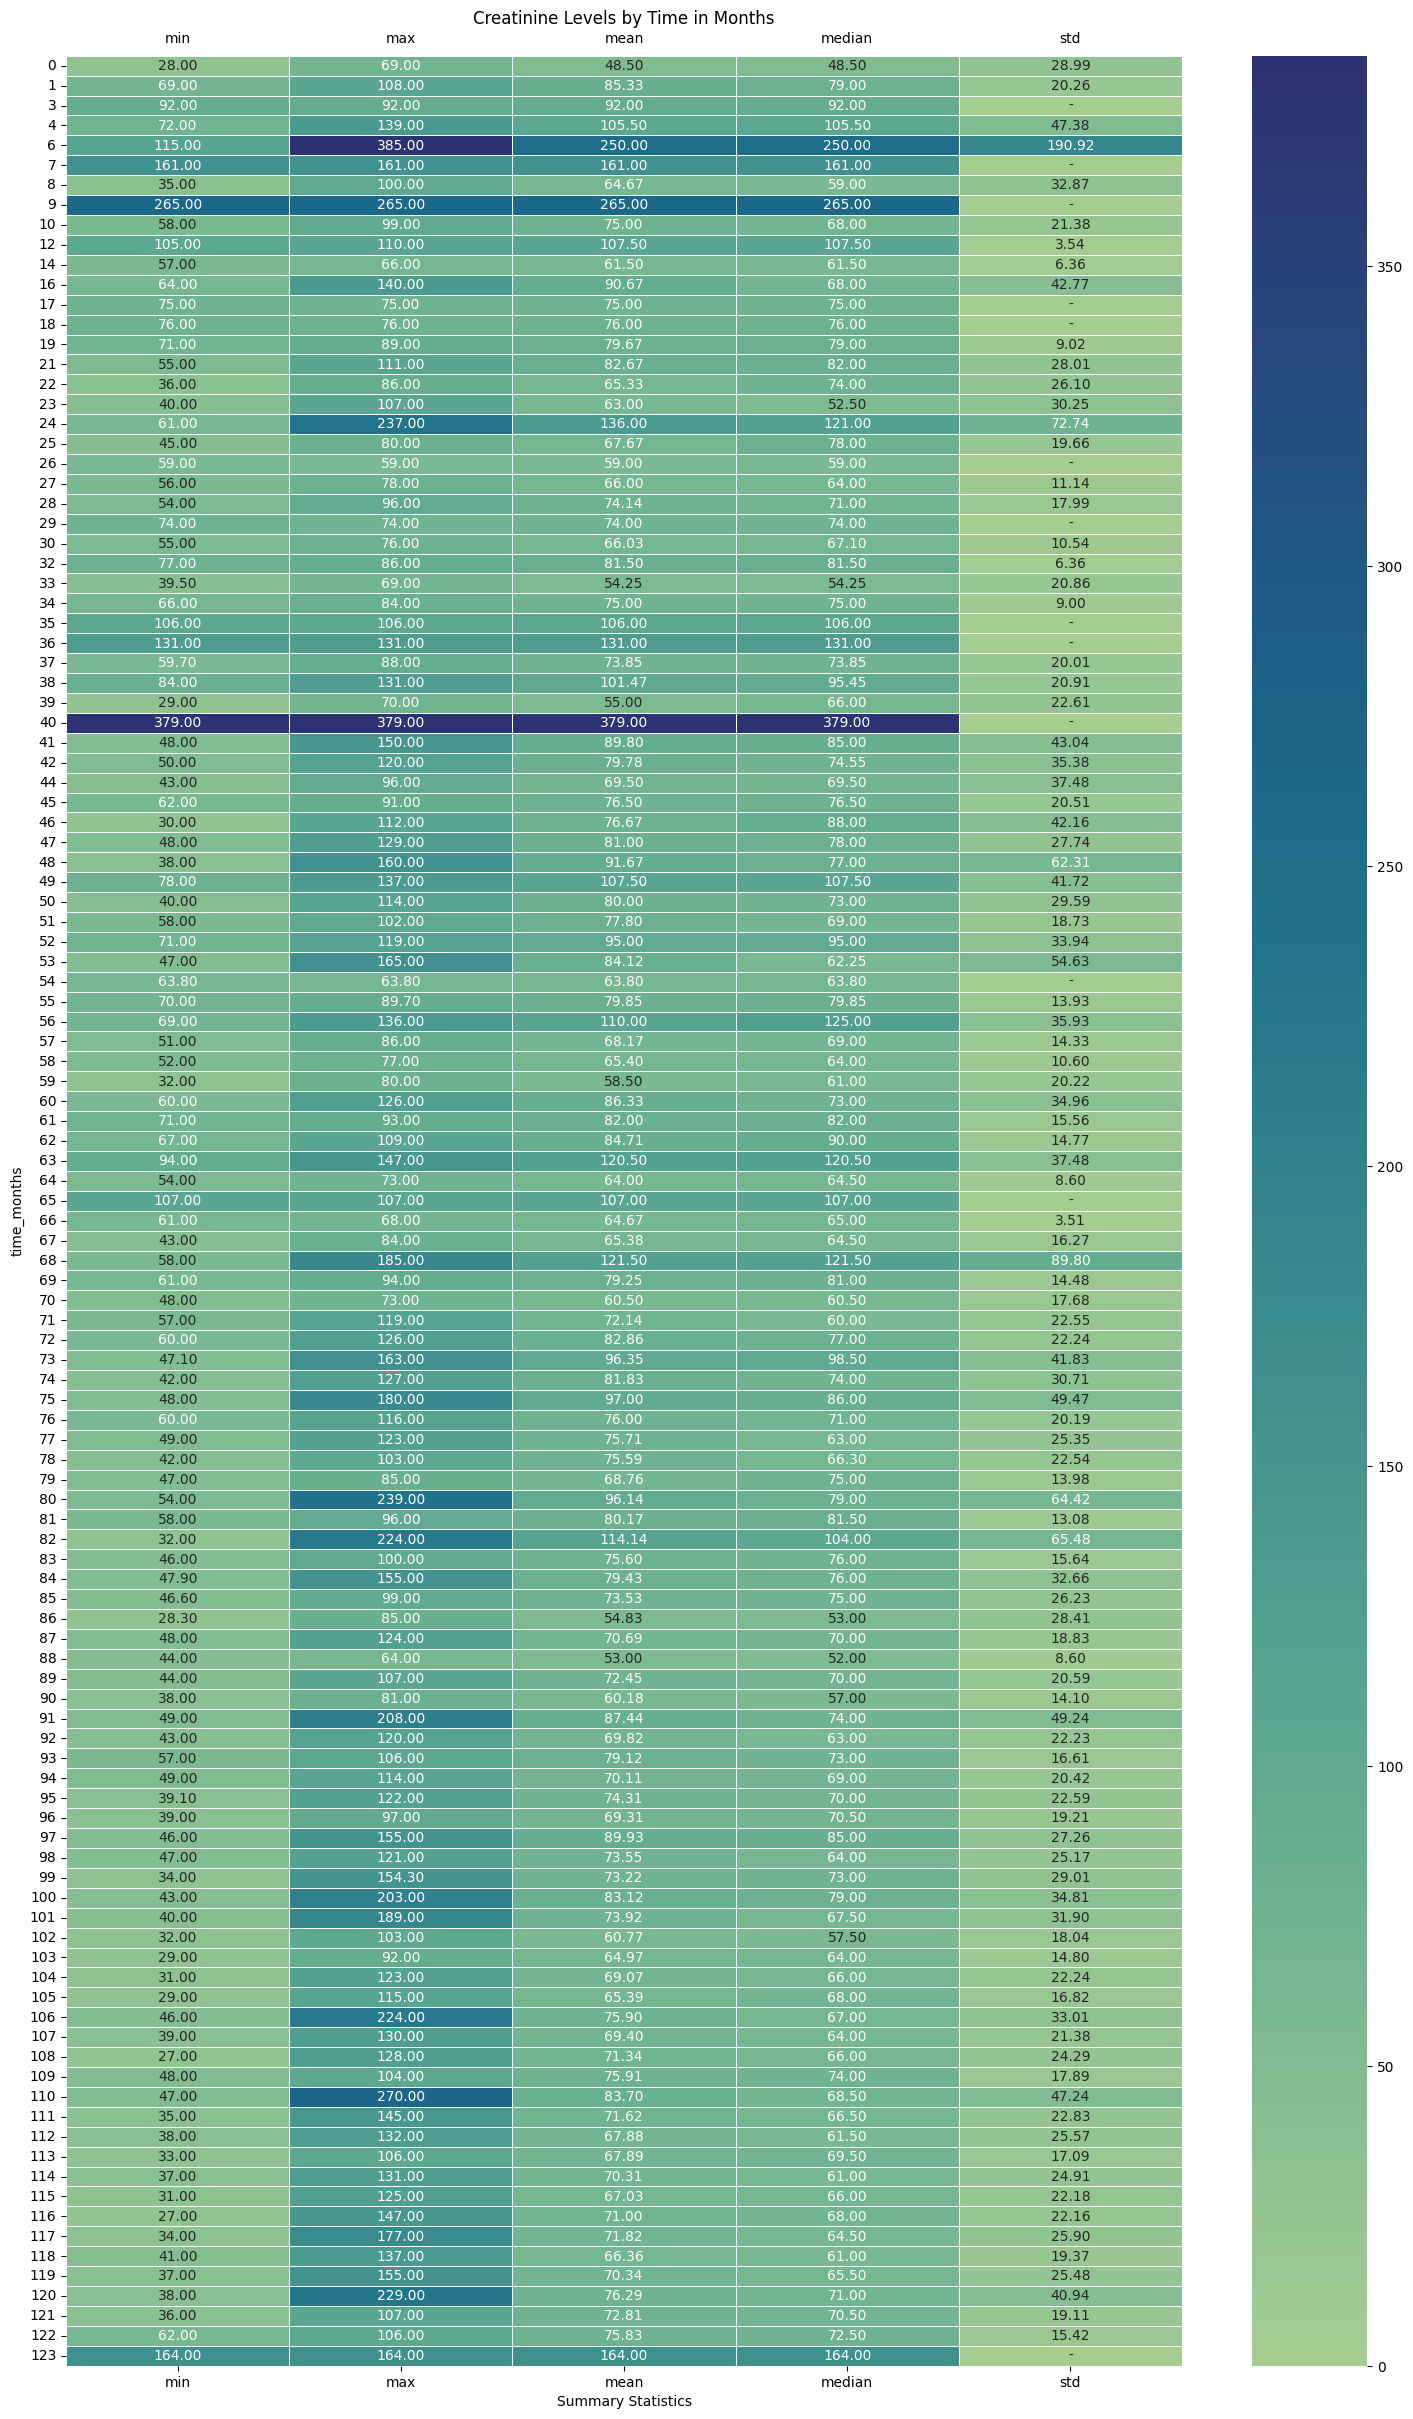

In [19]:
plt.figure(figsize=(18, 30))
sns.heatmap(
    df_eda.groupby("time_months")["creatinine"]
    .agg(["min", "max", "mean", "median", "std"])
    .fillna(0),
    annot=True,
    linewidths=0.5,
    fmt=".2f",
    cmap="crest",
)

# Replace 0s with "-" in the annotations.
for text in plt.gca().texts:
    if text.get_text() == "0.00":
        text.set_text("-")

# Set the title and move the x-axis to the top
plt.title("Creatinine Levels by Time in Months")

# Additional option: Rotate the x-axis labels if needed
plt.xticks(rotation=0)
plt.xlabel("Summary Statistics")
plt.tick_params(labeltop=True, labelbottom=True)
plt.savefig(os.path.join(image_path, "creatinine_levels_crosstab.svg"))
plt.show()

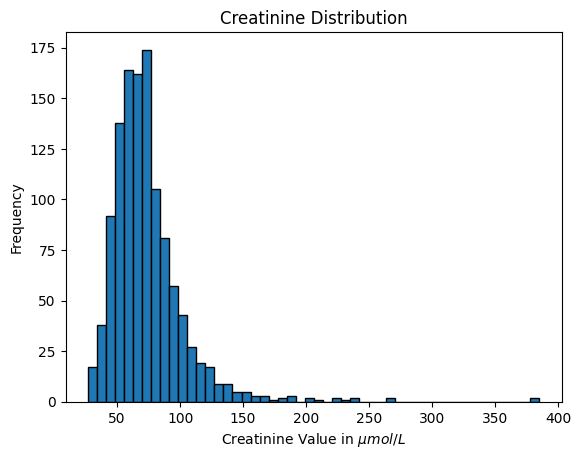

In [20]:
df_eda["creatinine"].hist(bins=50, edgecolor="black", grid=False)
plt.title("Creatinine Distribution")
plt.xlabel("Creatinine Value in $\mu mol/L$")
plt.ylabel("Frequency")
plt.savefig(os.path.join(image_path, "creatinine_hist.svg"))
plt.show()

In [21]:
df_eda["creatinine"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
creatinine,1186.0,74.362563,31.020906,27.0,56.025,69.0,84.0,385.0


## Survivability by Feature

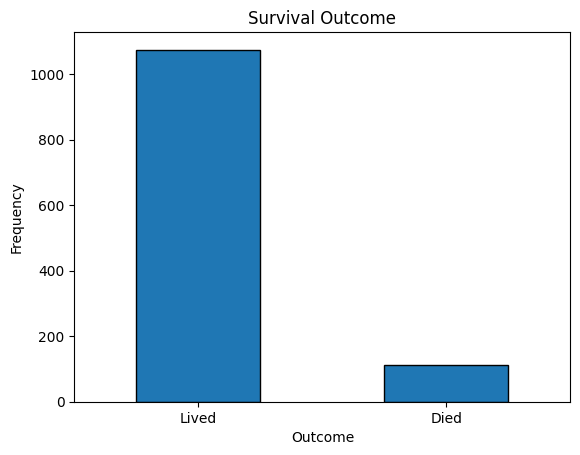


Lived    1074
Died      112
Name: outcome, dtype: int64


In [22]:
ax = df_eda["outcome"].value_counts().plot(kind="bar", rot=0, edgecolor="black")
new_labels = ["Lived", "Died"]
ax.set_xticklabels(new_labels)
plt.title("Survival Outcome")
plt.xlabel("Outcome")
plt.ylabel("Frequency")
plt.savefig(os.path.join(image_path, "survival_outcome.svg"))
plt.show()
print()
print(
    df_eda["outcome"].value_counts().rename({0: "Lived", 1: "Died"}),
)

In [23]:
bar_list = df_eda.columns.to_list()
bar_list_remove = ["time_months", "outcome", "creatinine"]
bar_list = [item for item in bar_list if item not in bar_list_remove]
bar_list

['sex',
 'cancer',
 'smoking',
 'obesity',
 'hypertension',
 'dyslipidemia',
 'diabetes',
 'cardiovascular_disease',
 'time_years',
 'year_bins']

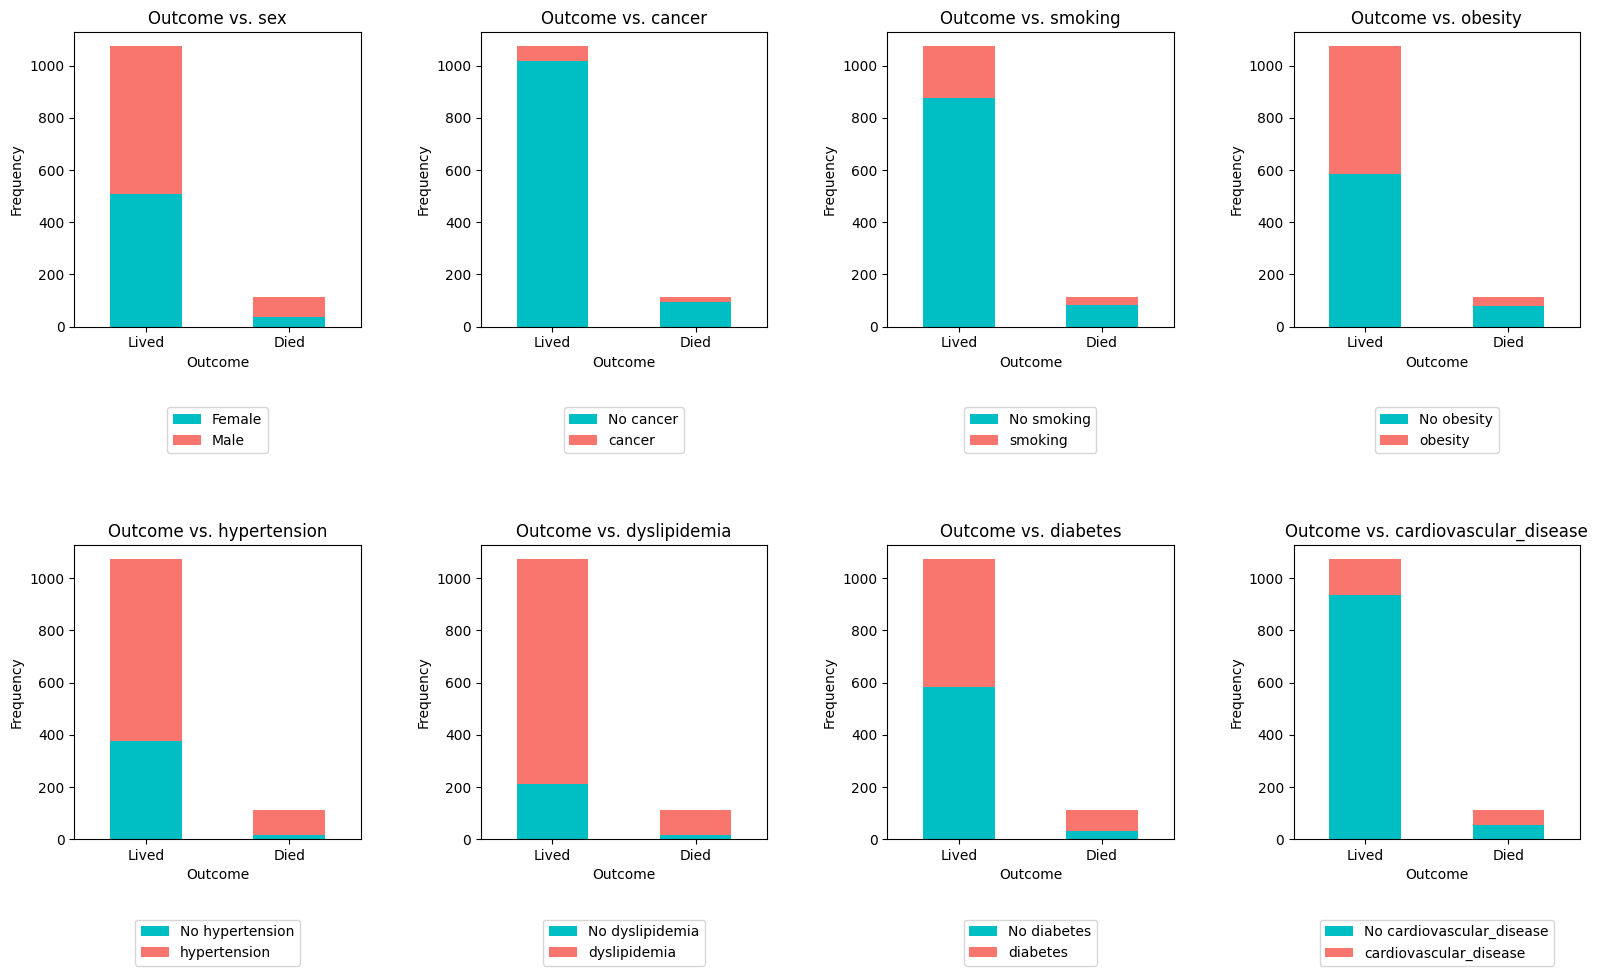

In [24]:
crosstab_plot(
    df=df_eda,
    sub1=2,
    sub2=4,
    x=16,
    y=10,
    list_name=bar_list,
    label1="Lived",
    label2="Died",
    col1="sex",
    item1="Female",
    item2="Male",
    bbox_to_anchor=(0.5, -0.25),
    w_pad=4,
    h_pad=4,
    crosstab_option=True,
    image_path=image_path,
    string="outcome_by_feature.svg",
)

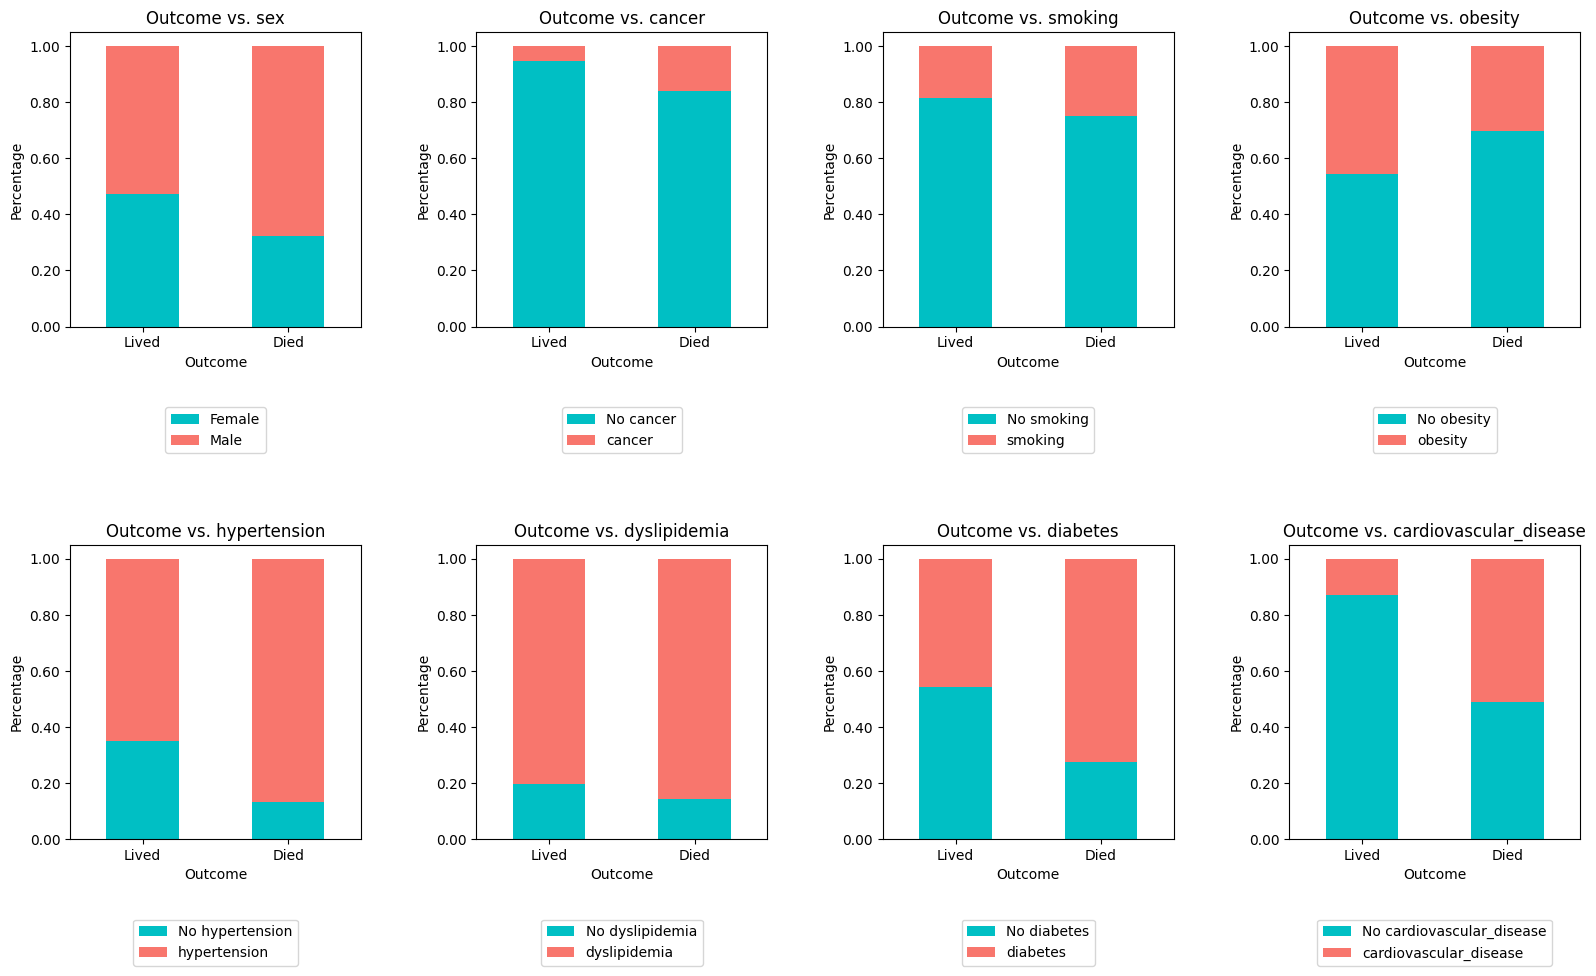

In [25]:
crosstab_plot(
    df=df_eda,
    sub1=2,
    sub2=4,
    x=16,
    y=10,
    list_name=bar_list,
    label1="Lived",
    label2="Died",
    col1="sex",
    item1="Female",
    item2="Male",
    bbox_to_anchor=(0.5, -0.25),
    w_pad=4,
    h_pad=4,
    crosstab_option=False,
    image_path=image_path,
    string="outcome_by_feature_normalized.svg",
)

In [26]:
outcome_by_years = pd.crosstab(
    df_eda["year_bins"], df_eda["outcome"], margins=True, margins_name="Total_Count"
).rename(
    columns={0: "Lived", 1: "Died"},
)
outcome_by_years["Lived_%"] = round(
    outcome_by_years["Lived"] / outcome_by_years["Total_Count"] * 100, 2
)
outcome_by_years["Died_%"] = round(
    outcome_by_years["Died"] / outcome_by_years["Total_Count"] * 100, 2
)
outcome_by_years["Total_%"] = outcome_by_years["Lived_%"] + outcome_by_years["Died_%"]
outcome_by_years

outcome,Lived,Died,Total_Count,Lived_%,Died_%,Total_%
year_bins,,,,,,
0-1_years,12,8,20,60.00,40.00,100.0
1-2_years,12,14,26,46.15,53.85,100.0
2-3_years,14,12,26,53.85,46.15,100.0
3-4_years,24,11,35,68.57,31.43,100.0
4-5_years,31,11,42,73.81,26.19,100.0
5-6_years,39,10,49,79.59,20.41,100.0
6-7_years,68,19,87,78.16,21.84,100.0
7-8_years,101,9,110,91.82,8.18,100.0
8-9_years,305,14,319,95.61,4.39,100.0


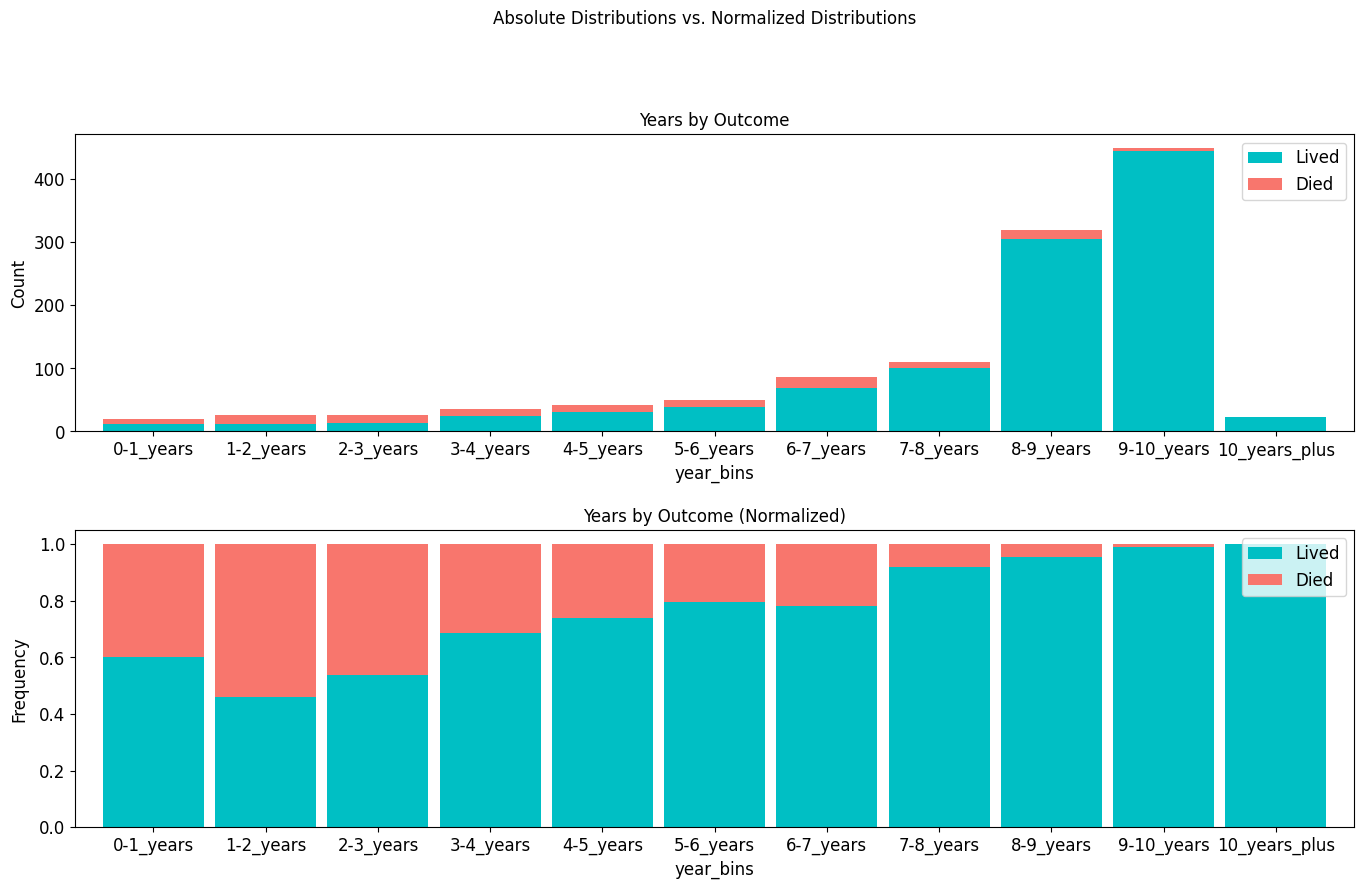

In [27]:
stacked_plot(
    x=16,
    y=10,
    p=10,
    df=df_eda,
    col="year_bins",
    truth="outcome",
    condition=1,
    kind="bar",
    ascending=False,
    width=0.9,
    rot=0,
    string="Years",
    custom_order=[
        "0-1_years",
        "1-2_years",
        "2-3_years",
        "3-4_years",
        "4-5_years",
        "5-6_years",
        "6-7_years",
        "7-8_years",
        "8-9_years",
        "9-10_years",
        "10_years_plus",
    ],
    legend_labels=["Lived", "Died"],
    image_path=image_path,
    img_string="years_by_outcome.svg",
)

# Modeling: Kidney_UAE

In [28]:
# paths to files
data_original = "/content/drive/MyDrive/kidney_uae/data/df_original/"
data_years = "/content/drive/MyDrive/kidney_uae/data/df_years/"

In [29]:
# save out the split datasets to separate parquet files
X_train = pd.read_parquet(os.path.join(data_original, "X_train.parquet"))
X_test = pd.read_parquet(os.path.join(data_original, "X_test.parquet"))
y_train = pd.read_parquet(os.path.join(data_original, "y_train.parquet"))
y_test = pd.read_parquet(os.path.join(data_original, "y_test.parquet"))
df_train = pd.read_parquet(os.path.join(data_original, "df_train.parquet"))
df_test = pd.read_parquet(os.path.join(data_original, "df_test.parquet"))
df = pd.read_parquet(os.path.join(data_original, "df_original.parquet"))
df_eda = pd.read_parquet(os.path.join(eda_path, "df_eda.parquet"))

In [30]:
## CPH-related joins to parse in "time_years" column and drop "time_months" col.
cph_train = df_train.join(df_eda["time_years"], on="id", how="inner").drop(
    columns=["time_months"]
)
cph_test = df_test.join(df_eda["time_years"], on="id", how="inner").drop(
    columns=["time_months"]
)

## Cox Proportional Hazards (CPH) Model

In [31]:
# Instantiate the CoxPHFitter
cph = CoxPHFitter(
    baseline_estimation_method="breslow",
)

# Fit the model with additional options for the optimization routine
cph.fit(
    cph_train,
    duration_col="time_years",
    event_col="outcome",
    weights_col="creatinine",
    robust=True,
    show_progress=True,
)

Iteration 1: norm_delta = 9.93e-01, step_size = 0.9500, log_lik = -107046.54058, newton_decrement = 5.73e+03, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.95e-01, step_size = 0.9500, log_lik = -102616.29589, newton_decrement = 5.67e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 2.22e-02, step_size = 0.9500, log_lik = -102088.67088, newton_decrement = 2.94e+00, seconds_since_start = 0.1
Iteration 4: norm_delta = 2.30e-04, step_size = 1.0000, log_lik = -102085.71877, newton_decrement = 2.18e-04, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.08e-08, step_size = 1.0000, log_lik = -102085.71855, newton_decrement = 2.91e-12, seconds_since_start = 0.1
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 70882.7 total observations, 61087.7 right-censored observations>

In [32]:
# To evaluate the model, we will use the predict method on the test set and then
# calculate the concordance index
cph_train_score = cph.score(cph_train, scoring_method="concordance_index")
cph_validation_score = cph.score(cph_train, scoring_method="concordance_index")

cph_train_score, cph_validation_score

(0.7851420554191512, 0.7851420554191512)

In [33]:
# print the summary of the model
# Print the summary of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 70882.7 total observations, 61087.7 right-censored observations>
             duration col = 'time_years'
                event col = 'outcome'
              weights col = 'creatinine'
          robust variance = True
      baseline estimation = breslow
   number of observations = 70882.7
number of events observed = 9795
   partial log-likelihood = -102085.72
         time fit was run = 2024-04-01 01:50:01 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
sex                      0.09       1.10       0.30            -0.50             0.68                 0.61                 1.98
cancer                   0.62       1.85       0.33            -0.02             1.25                 0.98                 3.50
smoking                  0.09       1.09       0.28            -0.46             0.64                 0.63                 1.90
obesity                 -0.71       0.49       0.25            -1.21            -0.22                 0.30                 0.81
hypertension             0.87       2.39       0.42             0.05             1.70                 1.05                 5.46
dyslipidemia            -1.10       0.33       0.42            -1.91            -0.28                 0.15                 0.76
diabetes                 0.57       1.76       0.30            -0.01             1.15                 0.99                 3.15
cardiovascular_disease   1.39       4.00       0.26             0.89             1.89                 2.43                 6.60

                         cmp to     z      p   -log2(p)
covariate                                              
sex                        0.00  0.31   0.75       0.41
cancer                     0.00  1.89   0.06       4.08
smoking                    0.00  0.32   0.75       0.41
obesity                    0.00 -2.81 <0.005       7.65
hypertension               0.00  2.07   0.04       4.70
dyslipidemia               0.00 -2.63   0.01       6.86
diabetes                   0.00  1.91   0.06       4.17
cardiovascular_disease     0.00  5.44 <0.005      24.13
---
Concordance = 0.79
Partial AIC = 204187.44
log-likelihood ratio test = 9921.64 on 8 df
-log2(p) of ll-ratio test = inf

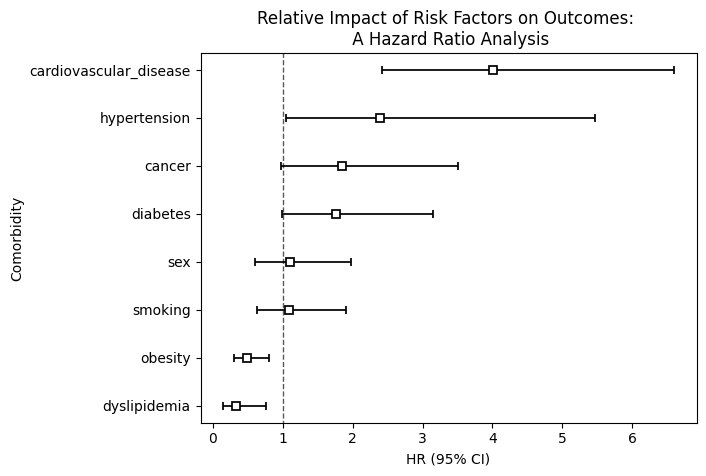

In [34]:
# Plot the results of the cph model with hazards ratios
cph.plot(hazard_ratios=True)
plt.title("Relative Impact of Risk Factors on Outcomes: \n A Hazard Ratio Analysis")
plt.ylabel("Comorbidity")
plt.savefig(
    os.path.join(image_path, "cph_hazard_ratios.svg"),
    bbox_inches="tight",
    dpi=300,
)
plt.show()

### Kaplan-Meier Estimates

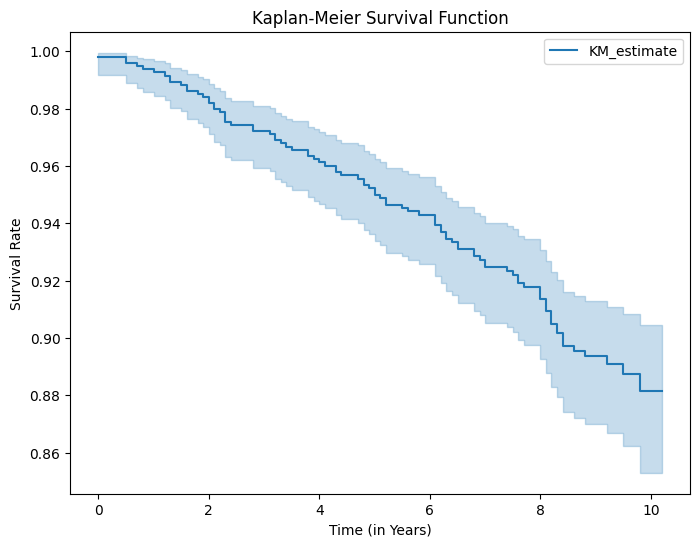

In [35]:
# Instantiate the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=cph_train["time_years"], event_observed=cph_train["outcome"])

# Plot the Kaplan-Meier estimate of the survival function
kmf.plot_survival_function(figsize=(8, 6))

plt.title("Kaplan-Meier Survival Function")
plt.xlabel("Time (in Years)")
plt.ylabel("Survival Rate")
plt.savefig(os.path.join(image_path, "kaplan_meier.svg"))
plt.show()  # Show the plot

### Partial Effects on Outcome

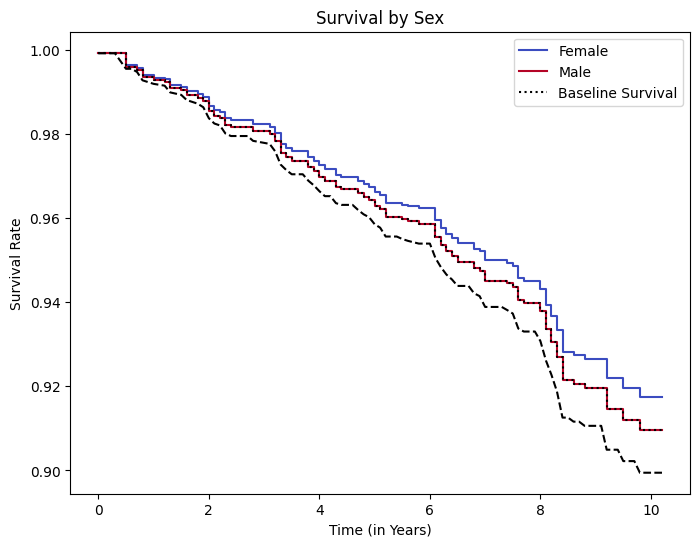

In [36]:
covariate = "sex"
# Then you define the values of the covariate you're interested in examining.
# For instance, if 'age' ranges from 20 to 70, you might choose a few key values within this range
values_of_interest = [0, 1]
labels = ["Female", "Male"]

# Generate the plot
ax = cph.plot_partial_effects_on_outcome(
    covariates=covariate, values=values_of_interest, cmap="coolwarm"
)

# Change the figure size here by accessing the figure object that 'ax' belongs to
ax.figure.set_size_inches(8, 6)

# Plot the baseline survival
cph.baseline_survival_.plot(
    ax=ax, color="black", linestyle="--", label="Baseline Survival"
)

# Manually construct the labels list including the baseline survival
labels_with_baseline = labels + ["Baseline Survival"]

# Retrieve the lines that have been plotted (which correspond to 'values_of_interest')
lines = ax.get_lines()

ax.set_title("Survival by Sex")
ax.set_xlabel("Time (in Years)")
ax.set_ylabel("Survival Rate")
ax.legend(lines, labels_with_baseline)  # Update the legend to include all lines
plt.savefig(os.path.join(image_path, "partial_effects_on_outcomes.svg"))
plt.show()  # Show the plot

## Customized Machine Learning Algorithms

In [37]:
rstate = 222  # random state for reproducibility

In [38]:
# untuned models
# lr = LogisticRegression(class_weight="balanced", random_state=rstate)
# svm = SVC(class_weight="balanced", probability=True, random_state=rstate)
# rf = RandomForestClassifier(class_weight="balanced", random_state=rstate)
# et = ExtraTreesClassifier(class_weight="balanced", random_state=rstate)

In [39]:
# Define pipelines and parameter grids for each model
# Pipelines define a sequence of data processing steps followed by a model
# Each pipeline begins with feature scaling using StandardScaler to standardize
# the data

# Logistic regression with balanced class weight
# Standardize features by removing the mean and scaling to unit variance
pipeline_lr = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features
        ("lr", LogisticRegression(class_weight="balanced", random_state=rstate)),
    ]
)

# SVM with balanced class weight
pipeline_svm = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardize features
        ("svm", SVC(class_weight="balanced", probability=True, random_state=rstate)),
    ]
)

# Random forest with balanced class weight
pipeline_rf = Pipeline(
    [
        ("rf", RandomForestClassifier(class_weight="balanced", random_state=rstate)),
    ]
)

# Define the Extra Trees pipeline; Extra Trees with balanced class weight
pipeline_et = Pipeline(
    [
        ("et", ExtraTreesClassifier(class_weight="balanced", random_state=rstate)),
    ]
)

# Define the parameter grids for each model. The keys are prefixed with the
# model's name from the pipeline followed by a double underscore to specify
# parameter names for hyperparameter tuning.

# Parameter grid for the Logistic Regression model
param_grid_lr = {
    "lr__C": [0.001, 0.01, 0.1, 1, 10],  # Inverse of regularization strength
    "lr__solver": ["liblinear", "saga"],  # Algorithm in the optimization problem
    "lr__n_jobs": [-1],  # Number of CPU cores used when parallelizing over classes
}

# Parameter grid for the SVM model
param_grid_svm = {
    "svm__C": [0.1, 1, 10],  # Penalty parameter C of the error term
    "svm__kernel": ["linear", "poly", "rbf", "sigmoid"],  # kernel type
}

# Parameter grid for the Random Forest model
param_grid_rf = {
    "rf__n_estimators": [50, 100, 200, 500],  # The number of trees in the forest
    "rf__max_depth": [None, 10, 20, 30],  # The maximum depth of the tree
    "rf__min_samples_split": [2, 5, 10],  # min no. of samp. to split internal node
    "rf__n_jobs": [-1],  # The number of jobs to run in parallel
}

# Parameter grid for the Extra Trees model
param_grid_et = {
    "et__n_estimators": [200, 500, 1000],  # The number of trees in the forest
    "et__max_depth": [None, 10, 20, 30],  # The maximum depth of the tree
    "et__min_samples_split": [2, 5, 10],  # min no. of samp. to split internal node
    "et__n_jobs": [-1],  # The number of jobs to run in parallel
}

# GridSearchCV is set up for each model, defining cross-validation (cv) strategy,
# scoring metric, and verbosity
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_svm = GridSearchCV(
    pipeline_svm,
    param_grid_svm,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring="accuracy",
    verbose=1,
)
grid_search_et = GridSearchCV(
    pipeline_et,
    param_grid_et,
    cv=5,
    scoring="accuracy",
    verbose=1,
)

### Fitting Models Without Calibration

In [40]:
model_list = [
    ("grid_search_lr", grid_search_lr),
    ("grid_search_svm", grid_search_svm),
    ("grid_search_rf", grid_search_rf),
    ("grid_search_et", grid_search_et),
]

non_calibrated_probas_dict = {}

for name, model in tqdm(model_list, desc="Fitting models"):
    print(f"\nFitting {name}...")
    model.fit(
        X_train, y_train
    )  # This fits GridSearchCV which in turn finds the best estimator
    print(f"\nBest parameters for {name}: \n{model.best_params_}")

    # Predictions and probabilities from the calibrated model
    model_scores = model.predict(X_test)
    model_probas = model.predict_proba(X_test)[:, 1]

    # Storing scores and probabilities in probas_dict
    non_calibrated_probas_dict[name + "_score"] = model_scores
    non_calibrated_probas_dict[name + "_proba"] = model_probas

Fitting models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting grid_search_lr...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting models:  25%|██▌       | 1/4 [00:01<00:03,  1.05s/it]


Best parameters for grid_search_lr: 
{'lr__C': 0.1, 'lr__n_jobs': -1, 'lr__solver': 'saga'}

Fitting grid_search_svm...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Fitting models:  50%|█████     | 2/4 [00:07<00:08,  4.01s/it]


Best parameters for grid_search_svm: 
{'svm__C': 0.1, 'svm__kernel': 'poly'}

Fitting grid_search_rf...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


Fitting models:  75%|███████▌  | 3/4 [02:33<01:09, 69.20s/it]


Best parameters for grid_search_rf: 
{'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'rf__n_jobs': -1}

Fitting grid_search_et...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


Fitting models: 100%|██████████| 4/4 [06:33<00:00, 98.50s/it] 


Best parameters for grid_search_et: 
{'et__max_depth': None, 'et__min_samples_split': 2, 'et__n_estimators': 200, 'et__n_jobs': -1}


### Fitting Models With Calibration

In [41]:
calibrated_models = {}
probas_dict = {}

for name, model in tqdm(model_list, desc="Fitting models"):
    print(f"\nFitting {name}...")
    model.fit(
        X_train, y_train
    )  # This fits GridSearchCV which in turn finds the best estimator
    print(f"\nBest parameters for {name}: \n{model.best_params_}")

    # Create a calibrated classifier from the best estimator of the grid search
    calibrated_clf = CalibratedClassifierCV(
        model.best_estimator_,
        method="isotonic",
        cv=5,
    ).fit(X_train, y_train)

    # Store the calibrated model for potential later use
    calibrated_models[name] = calibrated_clf

    # Predictions and probabilities from the calibrated model
    model_scores = calibrated_clf.predict(X_test)
    model_probas = calibrated_clf.predict_proba(X_test)[:, 1]

    # Storing scores and probabilities in probas_dict
    probas_dict[name + "_score"] = model_scores
    probas_dict[name + "_proba"] = model_probas

Fitting models:   0%|          | 0/4 [00:00<?, ?it/s]


Fitting grid_search_lr...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters for grid_search_lr: 
{'lr__C': 0.1, 'lr__n_jobs': -1, 'lr__solver': 'saga'}


Fitting models:  25%|██▌       | 1/4 [00:01<00:04,  1.56s/it]


Fitting grid_search_svm...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters for grid_search_svm: 
{'svm__C': 0.1, 'svm__kernel': 'poly'}


Fitting models:  50%|█████     | 2/4 [00:08<00:10,  5.01s/it]


Fitting grid_search_rf...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters for grid_search_rf: 
{'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'rf__n_jobs': -1}


Fitting models:  75%|███████▌  | 3/4 [02:38<01:11, 71.07s/it]


Fitting grid_search_et...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters for grid_search_et: 
{'et__max_depth': None, 'et__min_samples_split': 2, 'et__n_estimators': 200, 'et__n_jobs': -1}


Fitting models: 100%|██████████| 4/4 [06:52<00:00, 103.08s/it]



### Calibration Curves

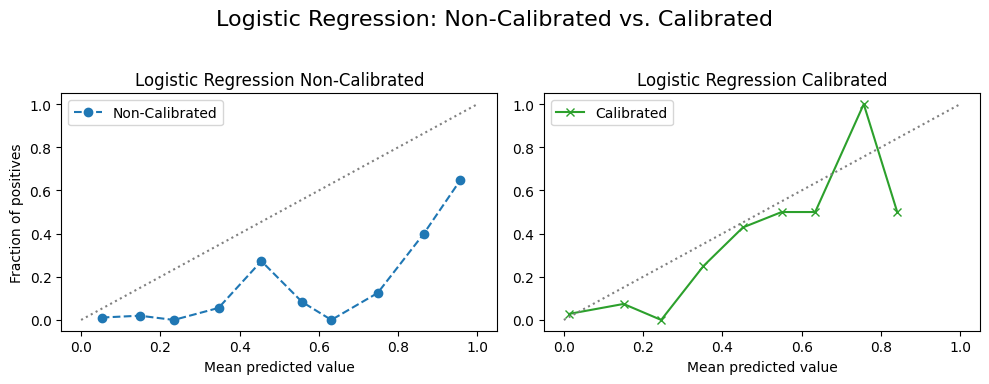

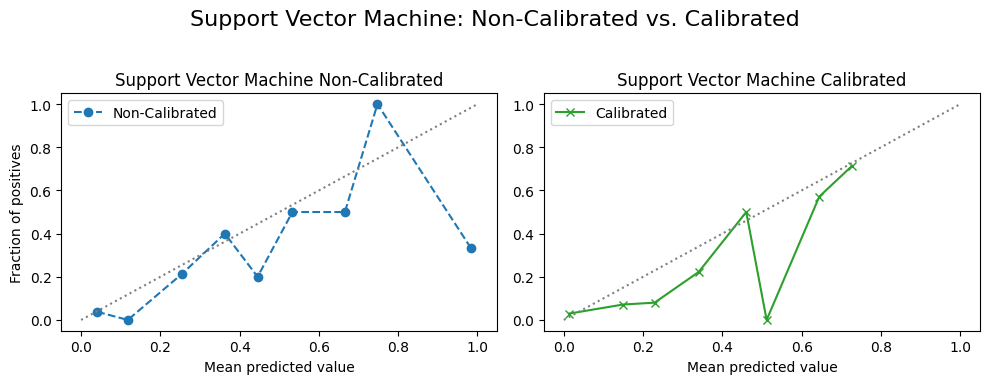

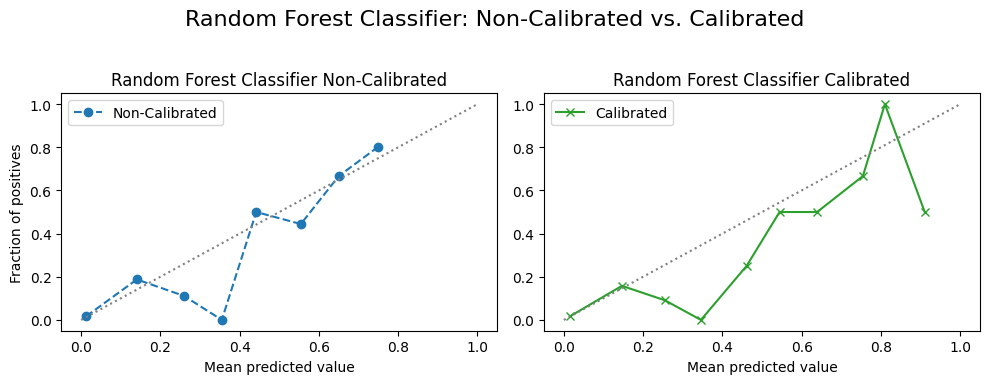

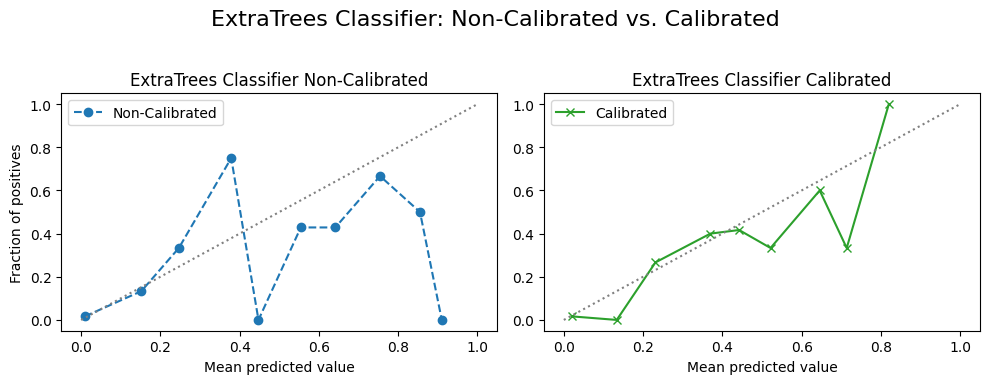

In [42]:
custom_titles = {
    "grid_search_lr": "Logistic Regression",
    "grid_search_svm": "Support Vector Machine",
    "grid_search_rf": "Random Forest Classifier",
    "grid_search_et": "ExtraTrees Classifier",
}

# Loop through each model to create a side-by-side plot for non-calibrated and
# calibrated models
for name, model in model_list:
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(10, 4)
    )  # figsize adjusted for two subplots side by side

    # Non-Calibrated Model
    prob_true_non_calib, prob_pred_non_calib = calibration_curve(
        y_test,
        non_calibrated_probas_dict[f"{name}_proba"],
        n_bins=10,
        strategy="uniform",
    )
    ax1.plot(
        prob_pred_non_calib,
        prob_true_non_calib,
        marker="o",
        linestyle="--",
        color="tab:blue",
        label="Non-Calibrated",
    )
    ax1.plot([0, 1], [0, 1], linestyle=":", color="gray")
    ax1.set_title(f"{custom_titles[name]} Non-Calibrated")  # Use custom title
    ax1.set_xlabel("Mean predicted value")
    ax1.set_ylabel("Fraction of positives")
    ax1.legend()

    # Calibrated Model
    prob_true_calib, prob_pred_calib = calibration_curve(
        y_test, probas_dict[f"{name}_proba"], n_bins=10, strategy="uniform"
    )
    ax2.plot(
        prob_pred_calib,
        prob_true_calib,
        marker="x",
        linestyle="-",
        color="tab:green",
        label="Calibrated",
    )
    ax2.plot([0, 1], [0, 1], linestyle=":", color="gray")
    ax2.set_title(f"{custom_titles[name]} Calibrated")  # Use custom title
    ax2.set_xlabel("Mean predicted value")
    ax2.legend()

    fig.suptitle(
        f"{custom_titles[name]}: Non-Calibrated vs. Calibrated",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    filename = f"{name}_non_calibrated_vs_calibrated.svg"
    filepath = os.path.join(image_path, filename)

    plt.savefig(filepath)  # Save the figure with the unique filename
    plt.show()

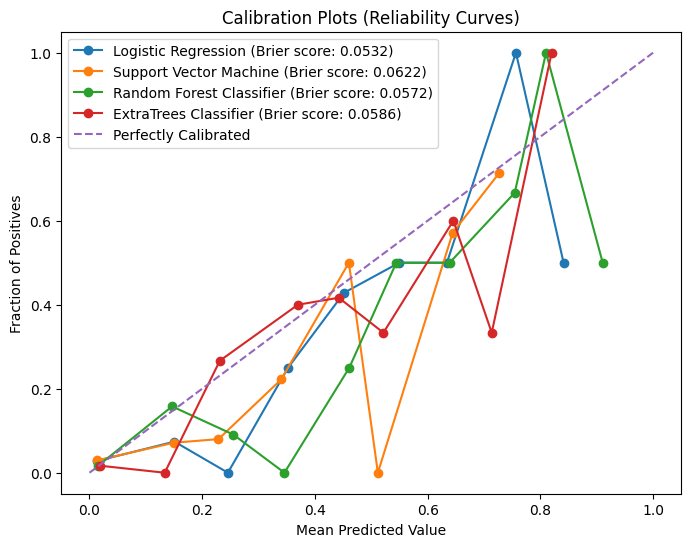

{'Logistic Regression': 0.05321798655726836,
 'Support Vector Machine': 0.06215359738495616,
 'Random Forest Classifier': 0.05723087367507125,
 'ExtraTrees Classifier': 0.058574661633233945}

In [43]:
model_dict = {
    "Logistic Regression": probas_dict["grid_search_lr_proba"],
    "Support Vector Machine": probas_dict["grid_search_svm_proba"],
    "Random Forest Classifier": probas_dict["grid_search_rf_proba"],
    "ExtraTrees Classifier": probas_dict["grid_search_et_proba"],
}

plot_calibration_curves(
    y_true=y_test,
    model_dict=model_dict,
    image_path=image_path,
    img_string="calibration_curves.svg",
)

## Performance Assessment

### Model Prediction Comparisons

In [44]:
proba_df = pd.DataFrame(
    {key: value for key, value in probas_dict.items() if key.endswith("proba")}
)

In [45]:
x_cols = [col for col in proba_df if not "grid_search_rf_proba" in col]
y_col = "grid_search_rf_proba"

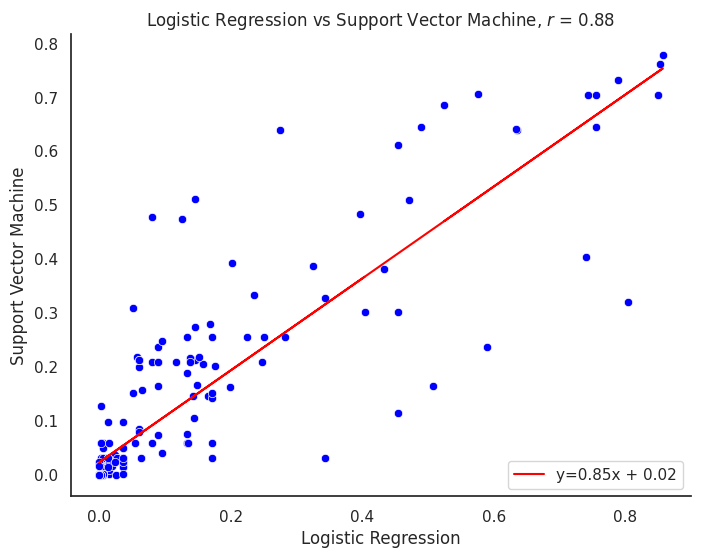

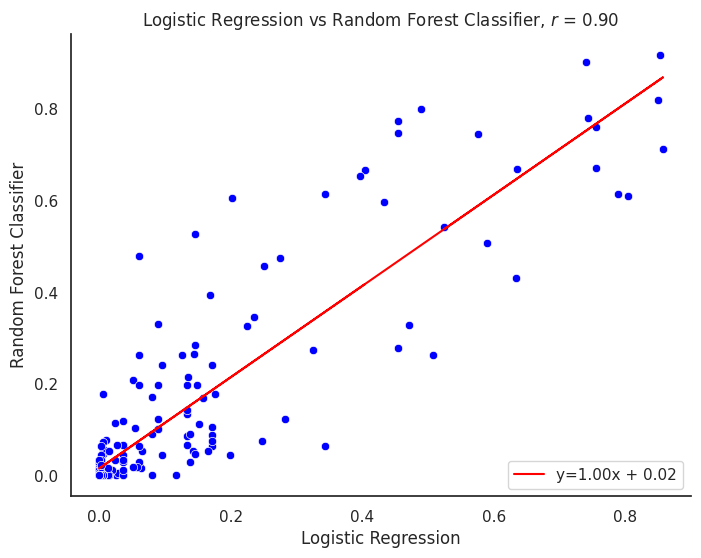

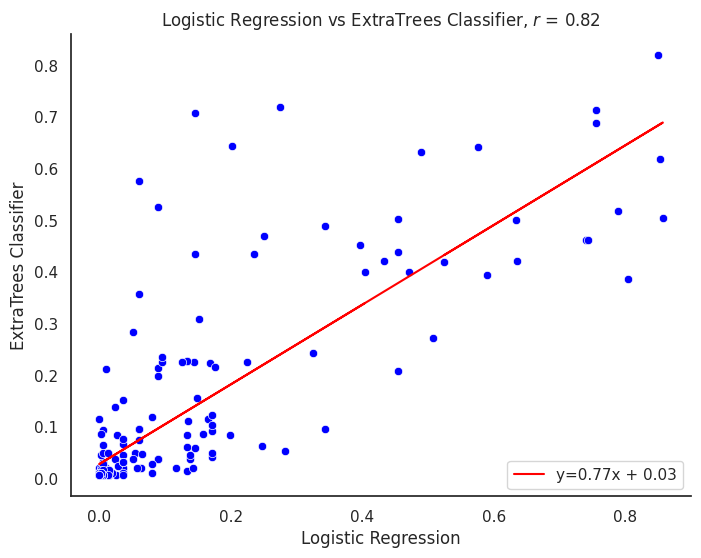

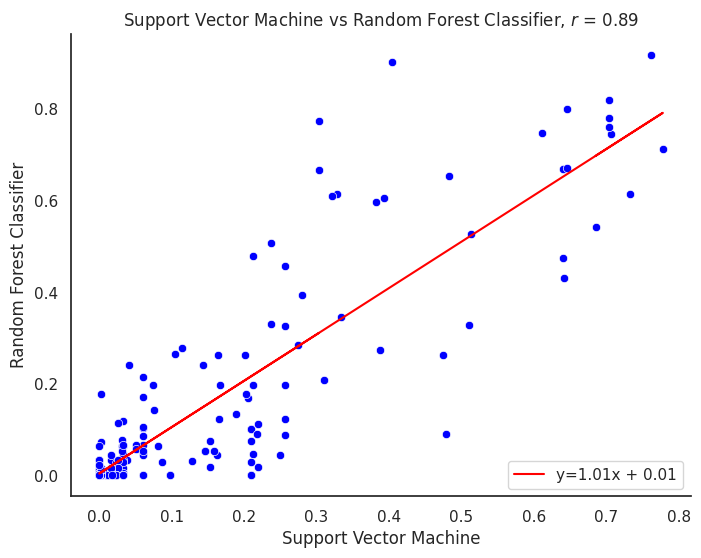

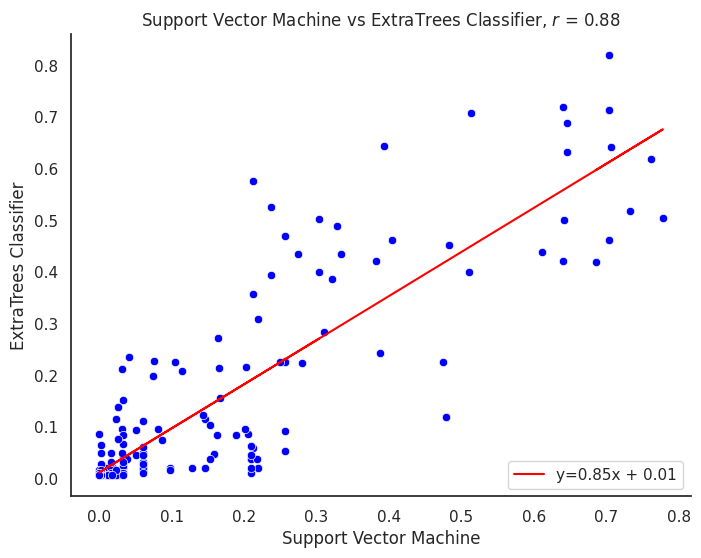

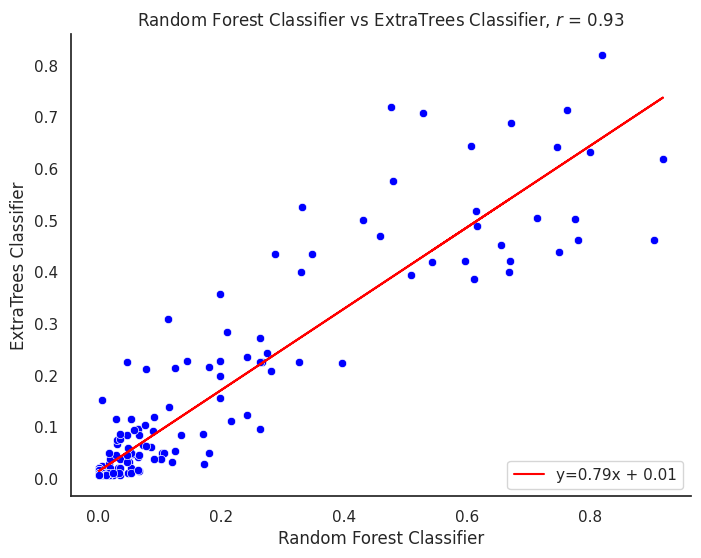

In [46]:
# Now plot scatter plots for each pair of columns
pairwise_combinations = list(combinations(proba_df.columns, 2))

# Set up the matplotlib figure
sns.set(style="white")

# Since we need to plot each scatterplot separately, let's iterate over the
# combinations again and plot them one by one.
# Iterate over each pair of columns
for col1, col2 in pairwise_combinations:
    plt.figure(figsize=(8, 6))

    # Find custom title for ea. column, if not found, use the column name itself
    title1 = custom_titles.get(col1.replace("_proba", ""), col1)
    title2 = custom_titles.get(col2.replace("_proba", ""), col2)

    # Set the plot title, x-label, and y-label using the custom titles
    plot_title = f"{title1} vs {title2}"
    x_label = title1
    y_label = title2

    corr_model = proba_df[col1].corr(proba_df[col2])
    m, b = np.polyfit(proba_df[col1], proba_df[col2], 1)
    line_label = f"y={m:.02f}x + {b:.02f}"
    plt.plot(proba_df[col1], m * proba_df[col1] + b, color="red", label=line_label)

    sns.scatterplot(data=proba_df, x=col1, y=col2, color="#0000ff")
    plt.title(f"{plot_title}, $r$ = {corr_model:.2f}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc="lower right")
    sns.despine()  # Optionally remove the top and right spines
    plt.savefig(os.path.join(image_path, f"{plot_title}.svg"))
    plt.show()


### AUROC Curves by Model

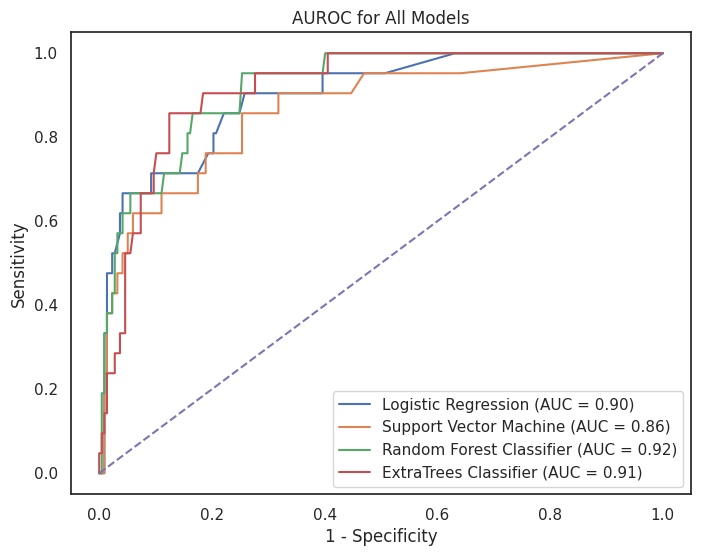

In [47]:
plt.figure(figsize=(8, 6))
for name, proba in model_dict.items():
    fpr, tpr, _ = roc_curve(y_test, proba)  # calculate values for TPR, FPR
    auc_models = auc(fpr, tpr)  # calculate the auc for all models
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_models:.2f})")  # plot the ROC AUC

plt.plot([0, 1], [0, 1], "--")
plt.title("AUROC for All Models")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend()
plt.savefig(os.path.join(image_path, "roc_auc_models.svg"))
plt.show()

In [48]:
metrics_df = evaluate_model_metrics(
    y_test=y_test,
    model_dict=model_dict,
    threshold=0.5,
)
metrics_df

Metric,Logistic Regression,Support Vector Machine,Random Forest Classifier,ExtraTrees Classifier,Best Model
AUC ROC,0.897520,0.863178,0.916831,0.914088,Random Forest Classifier
PR AUC,0.500029,0.431027,0.518698,0.466860,Random Forest Classifier
Precision,0.666667,0.562500,0.590909,0.466667,Logistic Regression
Recall,0.476190,0.428571,0.619048,0.333333,Random Forest Classifier
Specificity,0.976959,0.967742,0.958525,0.963134,Logistic Regression
Average Precision,0.520694,0.466152,0.545936,0.484984,Random Forest Classifier
Brier Score,0.053218,0.062154,0.057231,0.058575,Logistic Regression


### Confusion Matrix (Random Forest Model)

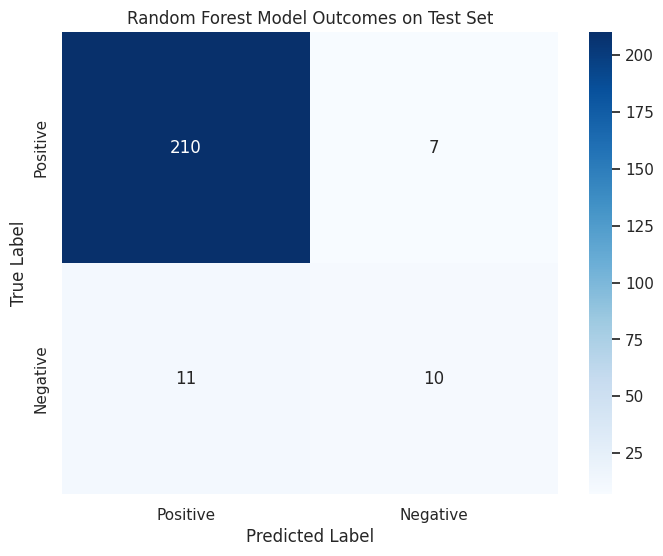

In [49]:
# Extract the feature names from X_train
feature_names = X_train.columns.to_list()

# Extract the best estimator from your grid_search_rf
# This indexes into grid_search_rf; adjust if necessary
best_rf_model = model_list[2][1].best_estimator_
rf_model = best_rf_model.named_steps["rf"]
y_pred = best_rf_model.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Positive", "Negative"],
    yticklabels=["Positive", "Negative"],
)
plt.title("Random Forest Model Outcomes on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig(os.path.join(image_path, "rf_confusion_matrix.svg"))
plt.show()

### Decision Tree from Random Forest Model

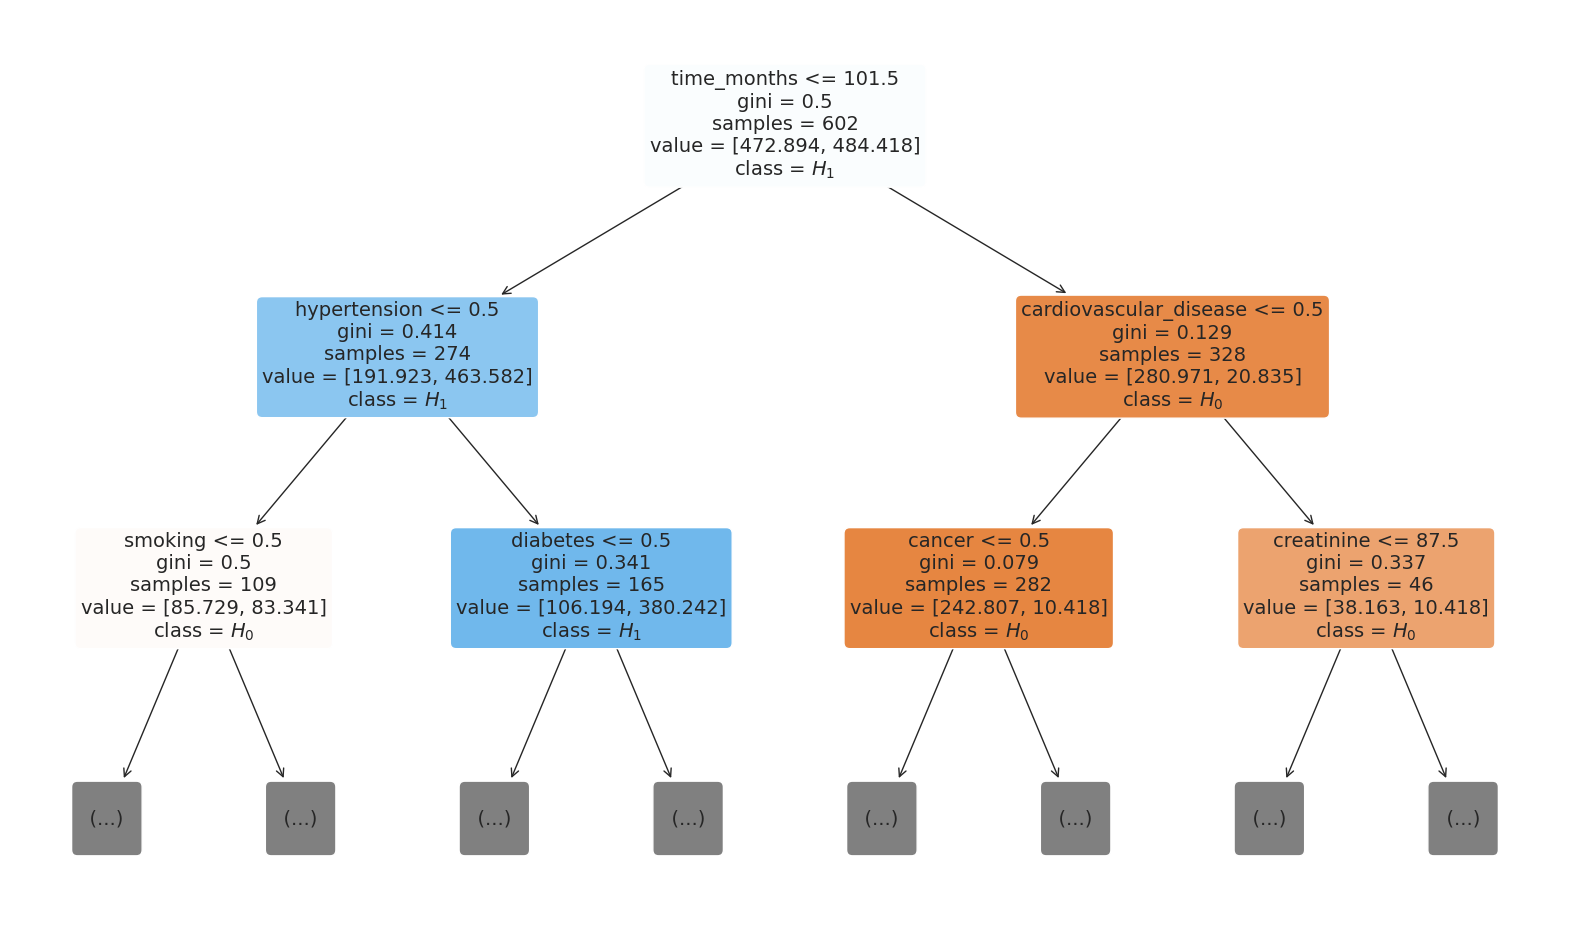

In [50]:
# Choose the tree you want to plot (e.g., the first tree)
chosen_tree = rf_model.estimators_[0]

# Plot the tree with a limited depth
plt.figure(figsize=(20, 12))

# Specify the class names as a list
class_names = ["$H_0$", "$H_1$"]

plot_tree(
    chosen_tree,
    filled=True,
    rounded=True,
    class_names=class_names,
    max_depth=2,  # Set the maximum depth to something low
    feature_names=X_test.columns,
    fontsize=14,
)
plt.savefig(
    os.path.join(image_path, "random_forest_viz.svg"), bbox_inches="tight", dpi=300
)
plt.show()

### Random Forest Feature Importances

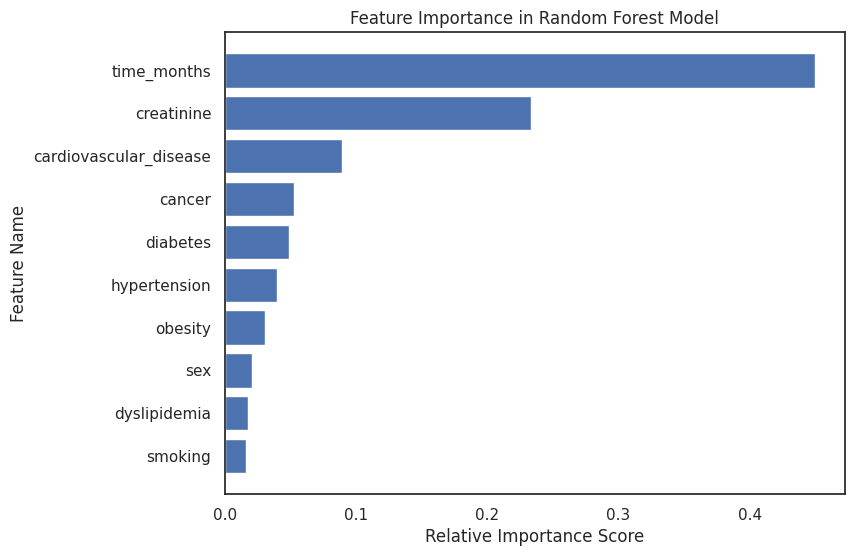

In [51]:
# Access the feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
sorted_names = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(8, 6))
plt.title("Feature Importance in Random Forest Model")
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), sorted_names)
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.xlabel("Relative Importance Score")
plt.ylabel("Feature Name")
plt.savefig(
    os.path.join(image_path, "rf_feat_importance.svg"), bbox_inches="tight", dpi=300
)
plt.show()

### SHAP Values

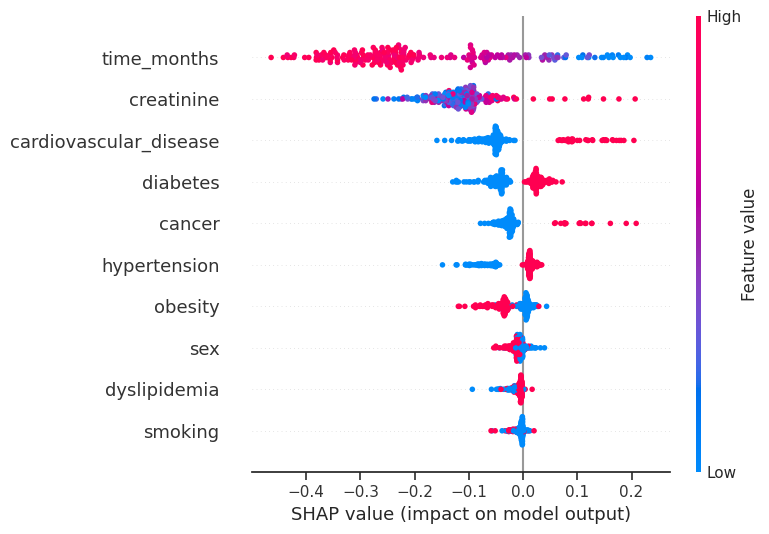

In [52]:
# Initialize the SHAP Explainer with your Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for your test set
shap_values = explainer.shap_values(X_test)

# Selecting SHAP values for the positive class
shap_values_positive_class = shap_values[:, :, 1]

# Now, shap_values_positive_class should have the correct shape
shap.summary_plot(
    shap_values_positive_class, X_test, feature_names=feature_names, show=False,
)

plt.savefig(
    os.path.join(image_path, "shap_value_importance.svg"), bbox_inches="tight",
    dpi=300,
)

plt.show()

### Partial Dependence

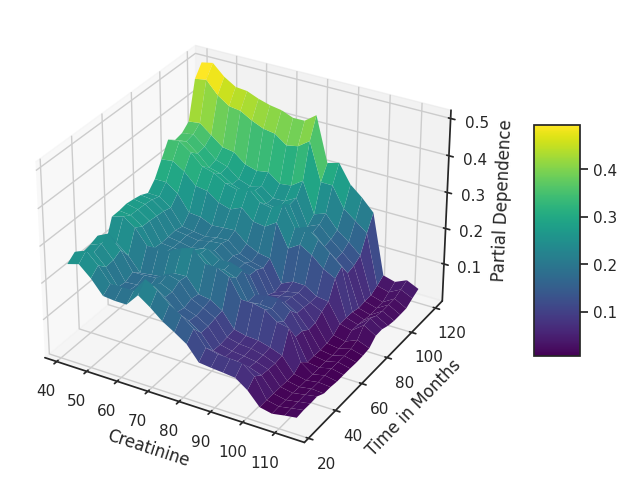

In [53]:
plot_3d_partial_dependence(
    model=rf_model,
    dataframe=X_test,  # or any DataFrame you choose
    feature_names_list=['creatinine', 'time_months'],
    x_label='Creatinine',
    y_label='Time in Months',
    z_label='Partial Dependence',
    title="",
    horizontal=0.99,
    depth=-1.25,
    vertical=0.99,
    html_file_path=image_path,
    html_file_name='interactive_partial_dependence.html',
    interactive=False,
    static=True,  # Set this to True to generate the static plot as well
    matplotlib_colormap='viridis',
    plotly_colormap='Viridis',
    zoom_out_factor=1.4,
)

# After the function call, save the current figure
plt.savefig(os.path.join(image_path, "static_partial_dependence.svg"), bbox_inches='tight',)

# If you want to display the plot as well
plt.show()

### AUROC by Feature

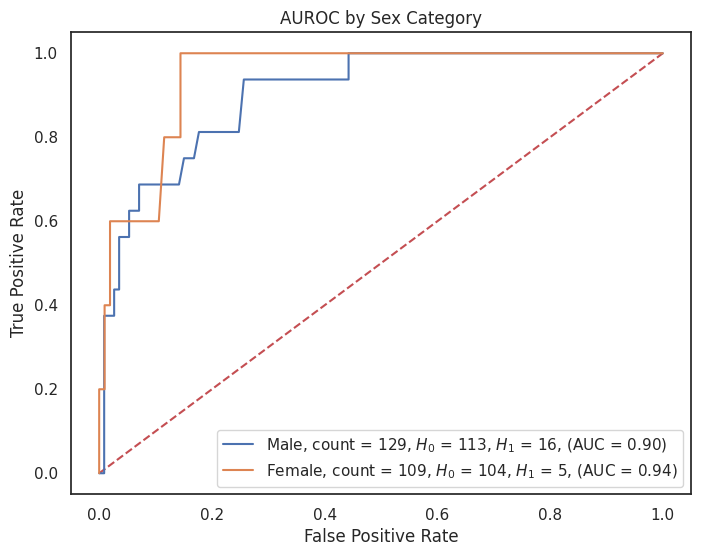

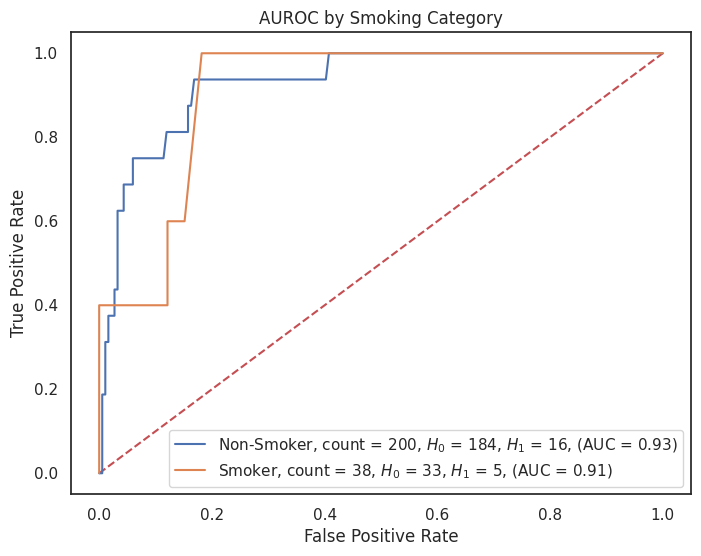

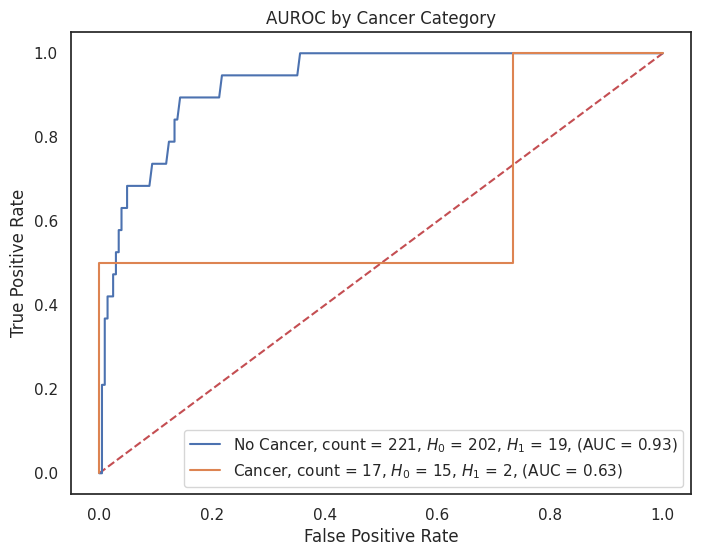

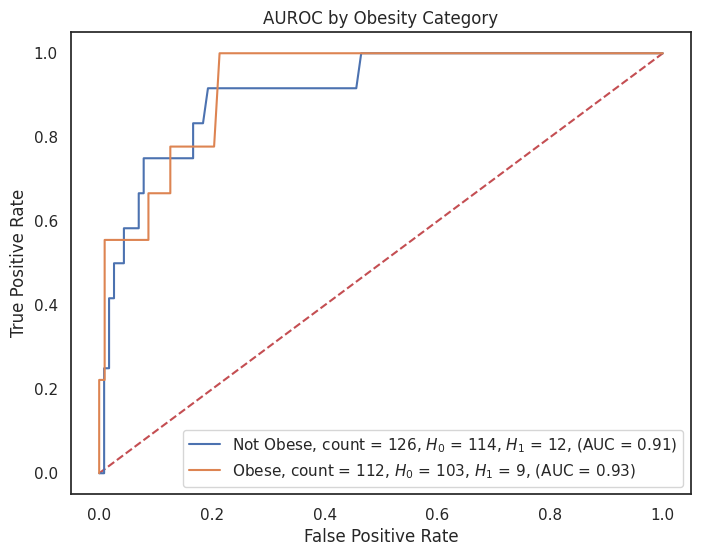

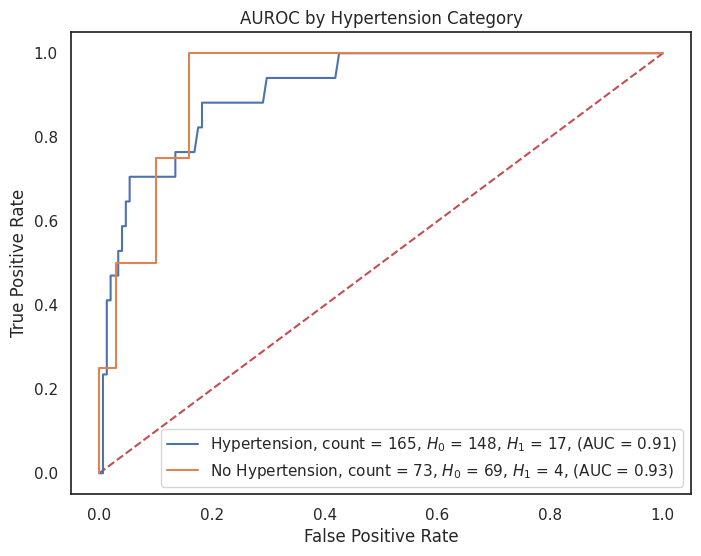

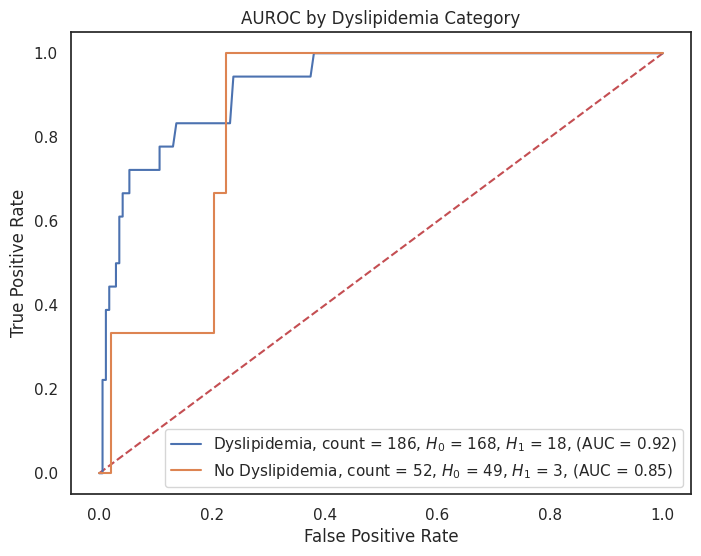

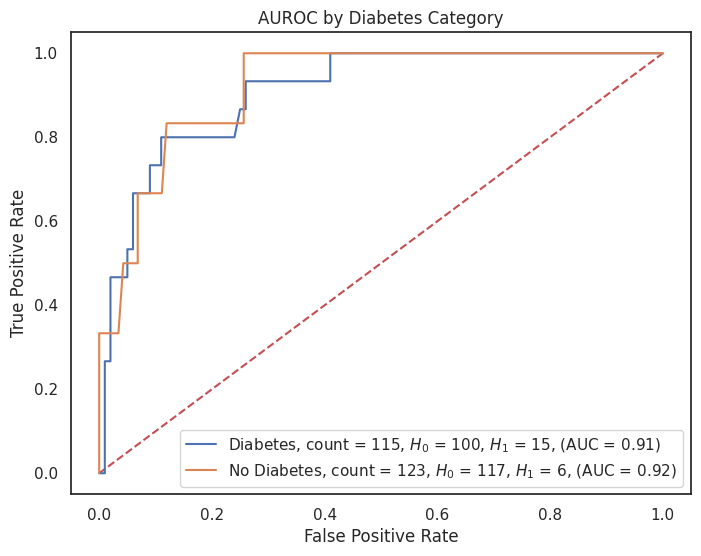

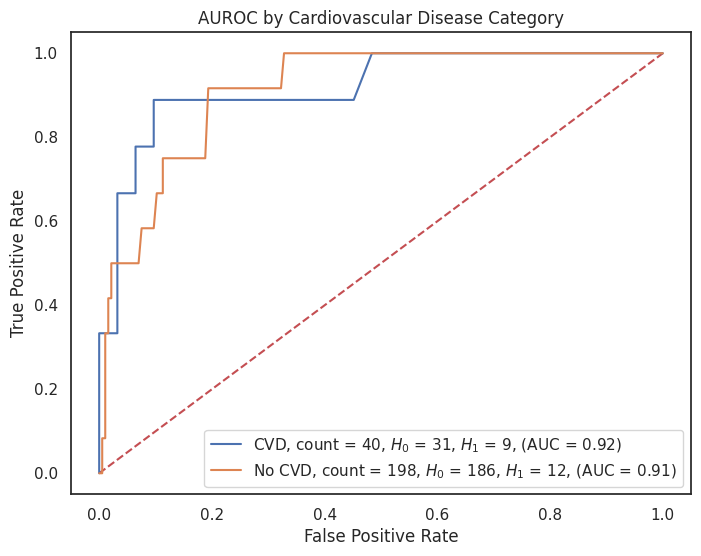

In [54]:
# Dictionary of model predictions
model_predictions = probas_dict["grid_search_rf_proba"]

# Dictionary of custom category labels for each column
category_label_dict = {
    "sex": {1: "Male", 0: "Female"},
    "smoking": {1: "Smoker", 0: "Non-Smoker"},
    "cancer": {1: "Cancer", 0: "No Cancer"},
    "obesity": {1: "Obese", 0: "Not Obese"},
    "hypertension": {1: "Hypertension", 0: "No Hypertension"},
    "dyslipidemia": {1: "Dyslipidemia", 0: "No Dyslipidemia"},
    "diabetes": {1: "Diabetes", 0: "No Diabetes"},
    "cardiovascular_disease": {1: "CVD", 0: "No CVD"}
    # Add more feature_label pairs as needed
}

# Loop over each feature you want to create a ROC plot for

for feature, category_labels in category_label_dict.items():
    title = f"AUROC by {feature.replace('_', ' ').title()} Category"
    plt.figure(figsize=(8, 6))
    plot_roc_curves_by_category(
        X_test=X_test,
        y_test=y_test,
        predictions=model_predictions,
        feature=feature,
        category_labels=category_labels,
        outcome="outcome",
        title=title,
        image_path=image_path,
        img_string=f"auc_roc_by_{feature}.svg",
    )

## Save Best Model's Predictions

In [55]:
model_df = pd.DataFrame(index=X_test.index)

# Add the scores to the DataFrame
for name, values in probas_dict.items():
    if name.endswith("_score"):
        model_df[name] = values
    elif name.endswith("_proba"):
        model_df[name] = values

In [56]:
pd.DataFrame(model_df["grid_search_rf_score"]).to_parquet(
    os.path.join(data_original, "rf_score.parquet")
)

## Bias & Fairness Analysis

In [57]:
# read the necessary parquet files from paths
df = pd.read_parquet(os.path.join(data_original, "df_original.parquet"))
y_test = pd.read_parquet(os.path.join(data_original, "y_test.parquet"))
rf_score = pd.read_parquet(os.path.join(data_original, "rf_score.parquet"))

In [58]:
df_audit = df.copy(deep=True)

In [59]:
df_audit["sex_cat"] = df_audit["sex"].apply(lambda x: "Male" if x == 1 else "Female")

In [60]:
audit_sex = y_test.join(rf_score, on="id", how="inner").join(
    df_audit["sex_cat"], on="id", how="inner"
)

In [61]:
audit_sex.head()

,outcome,grid_search_rf_score,sex_cat
id,,,
2346,0,1,Male
2394,0,0,Male
692,0,0,Female
68,0,0,Female
320,1,1,Male


In [62]:
audit_sex.shape

(238, 3)

In [63]:
audit_sex = move_column_before(
    df=audit_sex, target_column="grid_search_rf_score", before_column="sex_cat",
)

In [64]:
audit_sex.shape

(238, 3)

In [65]:
audit = Audit(df=audit_sex, score_column="grid_search_rf_score",
              label_column="outcome",)
audit.audit()

In [66]:
audit.confusion_matrix

pp   pn  fp  fn   tn  tp  group_label_pos  \
attribute_name attribute_value                                              
sex_cat        Female            6  103   3   2  101   3                5   
               Male             16  113   6   6  107  10               16   

                                group_label_neg  group_size  total_entities  
attribute_name attribute_value                                               
sex_cat        Female                       104         109             238  
               Male                         113         129             238

In [67]:
audit.metrics.round(2)

accuracy   tpr   tnr   for   fdr   fpr   fnr  \
attribute_name attribute_value                                                 
sex_cat        Female               0.95  0.60  0.97  0.02  0.50  0.03  0.40   
               Male                 0.91  0.62  0.95  0.05  0.38  0.05  0.38   

                                 npv  precision   ppr  pprev  prev  
attribute_name attribute_value                                      
sex_cat        Female           0.98       0.50  0.27   0.06  0.05  
               Male             0.95       0.62  0.73   0.12  0.12

In [68]:
audit.disparity_df.style

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,22,sex_cat,Female,0.954128,0.600000,0.971154,0.019417,0.500000,0.028846,0.400000,0.980583,0.500000,6,103,0.272727,0.055046,3,2,101,3,5,104,109,238,0.045872,0.375000,0.443807,0.800000,1.333333,0.365696,0.543269,1.066667,0.960000,1.025611,1.035568,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
1,0,binary 0/1,22,sex_cat,Male,0.906977,0.625000,0.946903,0.053097,0.375000,0.053097,0.375000,0.946903,0.625000,16,113,0.727273,0.124031,6,6,107,10,16,113,129,238,0.124031,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male


In [69]:
audit.disparities.style

In [70]:
metrics = ["fpr", "fdr", "pprev"]
disparity_tolerance = 1.25

In [71]:
audit_sex_groups = Audit(
    df=audit_sex,
    score_column="grid_search_rf_score",
    label_column="outcome",
    reference_groups={"sex_cat": "Male"},
)
audit_sex_groups.audit()

In [72]:
summary_plot_kidney = audit_sex_groups.summary_plot(
    metrics=metrics,
    fairness_threshold=disparity_tolerance,
)
summary_plot_kidney

alt.VConcatChart(...)

In [73]:
disparity_plot_kidney = audit.disparity_plot(
    metrics=metrics, attribute="sex_cat", fairness_threshold=disparity_tolerance
)
disparity_plot_kidney

alt.LayerChart(...)

## References

Al-Shamsi, S., Govender, R. D., & King, J. (2021). Predictive value of creatinine-based equations of kidney function in the long-term prognosis of United Arab Emirates patients with vascular risk. *Oman medical journal, 36*(1), e217. https://doi.org/10.5001/omj.2021.07


Al-Shamsi, S., Govender, R. D., & King, J. (2019). Predictive value of creatinine-based equations of kidney function in the long-term prognosis of United Arab Emirates patients with vascular risk [Dataset]. Mendeley Data, V1. https://data.mendeley.com/datasets/ppfwfpprbc/1



